In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Importing the dataset:

In [2]:
polish_data = pd.read_csv(r"C:\Users\chris\OneDrive\MSc\Kalman Filter - Polish Paper\polish_data.csv")

In [3]:
polish_data

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0,0,6062445,4368335,3.8,5.2,0.13
1,11,11,6062500,4368343,5.1,5.2,0.12
2,20,9,6062556,4368351,6.3,5.2,-0.10
3,29,9,6062600,4368359,5.3,5.4,0.35
4,39,10,6062655,4368367,8.8,5.3,-0.12
5,50,11,6062711,4368375,7.6,5.5,-0.42
6,60,10,6062766,4368383,3.4,5.5,0.33
7,71,11,6062822,4368391,6.7,5.5,-0.29
8,99,28,6062988,4368422,3.8,5.6,0.50
9,110,11,6063043,4368430,8.8,5.4,-0.07


# Discrete Kalman filter steps:

## State vector $X_i$

In [4]:
def stateVector(x_k, y_k, V_k,psi_k):
    return(np.array([x_k,y_k,V_k*(np.cos(psi_k)),V_k*(np.sin(psi_k))]))
    
stateVector(polish_data.iloc[1,[2]],polish_data.iloc[1,[3]],polish_data.iloc[1,[5]],polish_data.iloc[1,[4]])

array([X    6062500.0
Name: 1, dtype: float64,
       Y    4368343.0
Name: 1, dtype: float64,
       Vmps   NaN
rot    NaN
Name: 1, dtype: float64,
       Vmps   NaN
rot    NaN
Name: 1, dtype: float64], dtype=object)

In [5]:
polish_data.iloc[1,[2]]

X    6062500.0
Name: 1, dtype: float64

# Kalman Filter equations: 

## Estimated State Vector $\hat{x}^{-}_{k}$ : (Time update)

In [115]:
# Get the estimated state vector
def estimated_state_vector(A, x_k_1, B, mu_k, w_k_1):
    # A - tranition matrix
    # x_k_1 - previous state vector
    # B - Output matrix,
    # mu_k - control variable vector,
    # w_k_1 - previous state noise matrix
    part1 = A.dot(x_k_1)
    part2 = B.dot(mu_k)
    
    return part1 + part2 + w_k_1


NameError: name 'V' is not defined

## Process error Covariance  $P_k^{-}$ : (Time update)

In [7]:
def process_error_covariance(A, P_k_1,Q):
    # A - transition matrix
    # P_k_1 - previous state process covariance
    # Q - process noise covariance
    
    return A.dot(P_k_1).dot(np.transpose(A)) + Q



## Kalman Gain $K_k$ : (Filter measurement update)

In [8]:
def kalman_gain(P_k, H, R):
    # P_k - process error covariance
    # H - simply transformation matrix
    # R - sensor noise covariance
    inverse_part = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return P_k.dot(np.transpose(H).dot(inverse_part ))

## A posteriori estimate of state at step k, $\hat{x}_k$ : (Filter measurement update)

In [9]:
def a_posteriori_est_state_k(x_hat_k,K_k, z_k,H):
    # x_hat_k = a priori estimate state
    # K_k - Kalman Gain
    # H - simply transfomation matrix
    #z_k - actual measurement vector
    
    return x_hat_k + K_k.dot(z_k - H.dot(x_hat_k))

## Process error covariance matrix $P_k$ : (Filter measurement update)

In [10]:
def process_err_covariance_mat(I,K_k, H, P_k_est):
    # I - Identity matrix
    # K_k - Kalman gain
    # H - simply transition matrix
    # P_k_est - proccess error covariance ahead
    
    return (I - K_k.dot(H).dot(P_k_est))

# Symbol Meanings:

### SOG :$V$
### Longitude: $\Phi$
### Latetude: $\lambda$
### Course over ground: $\Psi$

# Convertion to the Cartesian coordinates:

### Getting the epsiloid WGS-84 format:

In [11]:
def e_squared(a,b):
    # a - semi major axis
    # b - semi minor axis
    return (a**2 - b**2)/(a**2)

### Radius of the curvature:

In [12]:
def N_rad_of_curvature(a,e,lat):
    # a - semi-major axis
    # e - square of first eccentric
    # lat - latetude
    N = a/(np.sqrt(1- e*(np.sin(lat)**2)))
    return N
    

### Cartesian Coordinates:

In [13]:
def X_coordinate(N,h,long, lat):
    # N - Curvature of the first vertical circle
    # h - height at point 'P'
    # long - longitude
    # lat - latitude
    return (N+h)*np.cos(long)*np.cos(lat)

def Y_coordinate(N,h,long, lat):
    # N - Curvature of the first vertical circle
    # h - height at point 'P'
    # long - longitude
    # lat - latitude
    return (N+h)*np.cos(long)*np.sin(lat)

def Z_coordinate(N,e,H):
    # N - Curvature of the first vertical circle
    # e - estimate of the squre of the first eccentric
    # H - height at point 'P'
    return (N - (1-e)+H)

## Conversion of types

### knots --> m/s


In [14]:
def knots_to_mps(kts):
    return kts*0.51444444

### rate of turn °/min --> °/sec

In [15]:
def rot_min_to_sec(rot_min):
    return rot_min/60

In [16]:
def radians_to_deg(rad):
    return rad*np.pi/180

def deg_to_rad(deg):
    return deg*180/np.pi

# Estimation of Coordinates with Linear Algorithm

### Exceleration in x & y axis

In [17]:
def calc_a_x(V_k, cog, rot, cog_k_1,delta_time):
    #V_k - Speed over ground
    #rot - rate of turn
    #cog - course over ground
    #cog_k_1 - course over ground at instance (k-1)
    #delta_time - difference in time between the current and previous step
    top = V_k*np.cos(radians_to_deg(cog + rot*delta_time)) - np.cos(radians_to_deg(cog_k_1))
    bottom = delta_time
    
    return top/bottom

def calc_a_y(V_k, cog, rot, cog_k_1,delta_time):
    #V_k - Speed over ground
    #rot - rate of turn
    #cog - course over ground
    #cog_k_1 - course over ground at instance (k-1)
    #delta_time - difference in time between the current and previous step
    top = V_k*np.sin(radians_to_deg(cog + rot*delta_time)) - np.sin(radians_to_deg(cog_k_1))
    bottom = delta_time
    
    return top/bottom

### Shift of coordinates in the X & Y axis

In [18]:
def delta_X(a_x,deltaTime):
    #a_x - acceleration in x-axis
    #deltaTime - change in time
    return a_x*(deltaTime**2)/2

def delta_Y(a_y,deltaTime):
    return a_y*(deltaTime**2)/2

 # Discrete Kalman Filtering Algorithm 

## Model state Vector $X_i$

In [19]:
def set_state_vector_Xi(x_k, y_k,cog, V_k):
    # x_k & y_k = UTM Coordinate
    # V_k = sog
    # cog = course over ground
    X_i = np.array([[x_k],
           [y_k],
           [V_k*np.cos(deg_to_rad(cog/3600))], #/3600 is to convert the format from E10h
           [V_k*np.sin(deg_to_rad(cog/3600))]])
    return X_i
    

In [20]:
set_state_vector_Xi(6062445,4368335,3.8,5.2)

array([[6.06244500e+06],
       [4.36833500e+06],
       [5.19049289e+00],
       [3.14298484e-01]])

## Transition Matrix $A$ :

In [21]:
def getA(diffTime):
    A = np.identity(4)
    A[0,2] = diffTime
    A[1,3] = diffTime
    return A
    


In [22]:
A = getA(10) #Specified on page 79
print(A)

[[ 1.  0. 10.  0.]
 [ 0.  1.  0. 10.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


## Predicted state matrix $\hat{x}^{-}_{k}$ :

In [23]:
def pred_state_mat(a_x,a_y,timeDiff,A,prev_state_mat,w_k_1):
    # a_x - acceleration in x-axis
    # a_y - acceleration in y-axis
    # timeDiff - timeDifference between intervals
    # prev_state - previous state matrix
    # w_k_1 - noise 
    B_mu_k = np.array([[a_x*(timeDiff**2)/2],
             [a_y*(timeDiff**2)/2],
             [a_x*timeDiff],
             [a_y*timeDiff]])
    
    
    return A.dot(prev_state_mat) + B_mu_k + w_k_1

## State proces covariance matrix $P_{k-1}$

In [24]:
def state_proccess_cov_mat(vec_in):
    cov_mat = vec_in.dot(np.transpose(vec_in))
    return cov_mat

In [25]:
P_k_1 = state_proccess_cov_mat(np.array([[10],[10],[0.5],[0.5]]))
print(P_k_1)

[[100.   100.     5.     5.  ]
 [100.   100.     5.     5.  ]
 [  5.     5.     0.25   0.25]
 [  5.     5.     0.25   0.25]]


## Q $\approxeq P_{k-1}$

In [26]:
Q = P_k_1
print(Q)

[[100.   100.     5.     5.  ]
 [100.   100.     5.     5.  ]
 [  5.     5.     0.25   0.25]
 [  5.     5.     0.25   0.25]]


### Transition Matrix $H$

In [27]:
H = np.identity(4)
print(H)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [28]:
P_k = process_error_covariance(A, P_k_1,Q)

#process_error_covariance(A, P_k_1,Q):

In [29]:
R = np.diagonal(P_k_1) #extract the diagona
a = np.zeros((4,4))
np.fill_diagonal(a,R)

R = copy.deepcopy(a) #make its own instance
print(R)


[[100.     0.     0.     0.  ]
 [  0.   100.     0.     0.  ]
 [  0.     0.     0.25   0.  ]
 [  0.     0.     0.     0.25]]


In [30]:
KalmanGain = kalman_gain(P_k, H, R)
print(KalmanGain)

[[0.3  0.3  4.   4.  ]
 [0.3  0.3  4.   4.  ]
 [0.01 0.01 0.2  0.2 ]
 [0.01 0.01 0.2  0.2 ]]


## Actual measurement vector $z_k$ 

In [31]:
def get_actual_measuremet_vec(x_k, y_k,cog, V_k):
    # x_k & y_k = UTM Coordinate
    # V_k = sog
    # cog = course over ground
    X_i = [[x_k],
           [y_k],
           [V_k*np.cos(deg_to_rad(cog/3600))], #/3600 is to convert the format from E10h
           [V_k*np.sin(deg_to_rad(cog/3600))]]
    return X_i
    

In [32]:
V_k = polish_data.iloc[1,5]
print("V_k: ",V_k)

cog = polish_data.iloc[1,4]
print("cog: ", cog)

cog_k_1 = polish_data.iloc[0,4]
print("cog_k_1: ", cog_k_1)

rot = polish_data.iloc[1,6]
print("rot: ", rot)

deltaTime = polish_data.iloc[1,1]
print("deltaTime: ", deltaTime)

a_x = calc_a_x(V_k,cog,rot,cog_k_1,deltaTime)
print("a_x: ",a_x)

a_y = calc_a_y(V_k,cog,rot,cog_k_1,deltaTime)
print("a_y: ",a_y)
#V_k, cog, rot, cog_k_1,delta_time):

X_coord = polish_data.iloc[1,2]
print("X_coord: ",X_coord)
Y_coord = polish_data.iloc[1,3]
print("Y_coord: ",Y_coord)

#MEASUREMENT VECTOR
z_k = get_actual_measuremet_vec(X_coord, Y_coord,cog, V_k)

print("\n\nMEASUREMENT VECTOR:\n",z_k)


V_k:  5.2
cog:  5.1
cog_k_1:  3.8
rot:  0.12
deltaTime:  11
a_x:  0.379053551321072
a_y:  0.04683348563913017
X_coord:  6062500
Y_coord:  4368343


MEASUREMENT VECTOR:
 [[6062500], [4368343], [5.182879536903919], [0.4216155902509045]]


## A posteriori Estimate $\hat{x}_k$ :

In [33]:
prev_state_mat = np.zeros(4)
w_k_1 = np.array([[0],[0],[0],[0]])

    
x_hat_k_dash = pred_state_mat(a_x,a_y,deltaTime,A,prev_state_mat, w_k_1) #Calculating $\hat{x}_k^{-}$
print(x_hat_k_dash)





# NOW FOR THE  a posteriori:
print("\n\nA posteriori:\n")

x_hat_k = a_posteriori_est_state_k(x_hat_k_dash,KalmanGain, z_k,H)
print(x_hat_k)



[[22.93273985 22.93273985 22.93273985 22.93273985]
 [ 2.83342588  2.83342588  2.83342588  2.83342588]
 [ 4.16958906  4.16958906  4.16958906  4.16958906]
 [ 0.51516834  0.51516834  0.51516834  0.51516834]]


A posteriori:

[[3129271.78184102 3129271.78184102 3129271.78184102 3129271.78184102]
 [3129251.68252705 3129251.68252705 3129251.68252705 3129251.68252705]
 [ 104312.52587495  104312.52587495  104312.52587495  104312.52587495]
 [ 104308.87145423  104308.87145423  104308.87145423  104308.87145423]]


## Process error covariance:

In [34]:
P_k = process_error_covariance(A, P_k_1,Q)
print(P_k)
    

[[325.  325.   12.5  12.5]
 [325.  325.   12.5  12.5]
 [ 12.5  12.5   0.5   0.5]
 [ 12.5  12.5   0.5   0.5]]


## If there is no coordinates it is estimated as follows:

In [35]:
y_k = copy.deepcopy(z_k[1])
print(y_k)

x_k = copy.deepcopy(z_k[0])
print(x_k)

def estimate_cog(x_k, x_k_1, y_k,y_k_1):

    cog_radians = np.arctan((y_k-y_k_1)/(x_k-x_k_1))

    
    return radians_to_deg(cog_radians)

cog_hat = estimate_cog(x_k[0], 0, y_k[0],0)
print("Estimated cog:", cog_hat)


def estimate_linspead(cog,sog):
    V_k_x = np.cos(deg_to_rad(cog))*sog
    V_k_y = np.sin(deg_to_rad(cog))*sog
    
    return np.array([V_k_x,V_k_y])

estimate_linspead(cog_hat,5)

[4368343]
[6062500]
Estimated cog: 0.010897593569502224


array([4.05661074, 2.92299664])

# Own inference before any Application of the Discrete Kalman filter:

In [36]:
polish_data

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0,0,6062445,4368335,3.8,5.2,0.13
1,11,11,6062500,4368343,5.1,5.2,0.12
2,20,9,6062556,4368351,6.3,5.2,-0.10
3,29,9,6062600,4368359,5.3,5.4,0.35
4,39,10,6062655,4368367,8.8,5.3,-0.12
5,50,11,6062711,4368375,7.6,5.5,-0.42
6,60,10,6062766,4368383,3.4,5.5,0.33
7,71,11,6062822,4368391,6.7,5.5,-0.29
8,99,28,6062988,4368422,3.8,5.6,0.50
9,110,11,6063043,4368430,8.8,5.4,-0.07


MSE:  2.601671458225936
Correlation Coef:
 [[1.         0.99989403]
 [0.99989403 1.        ]]


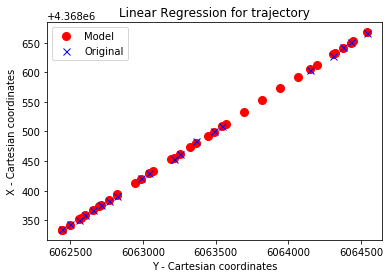

In [37]:
X_sog = np.arange(0,40)
X_sog = polish_data.iloc[:,2].values
Y_sog = polish_data.iloc[:,3]


model = LinearRegression()
model.fit(X_sog.reshape((-1,1)),Y_sog)
m = model.intercept_
coef = model.coef_
X_pred =  np.arange(start = np.min(X_sog), stop = np.max(X_sog), step = 125)
X_pred = np.concatenate((X_pred,X_sog),axis = 0)
Y_pred = X_pred*coef + m




#Original data

#Predicted with model
plt.plot(X_pred, Y_pred, 'ro', markersize=8)
plt.plot(X_sog, Y_sog, 'bx',markersize=7)
plt.title("Linear Regression for trajectory")
plt.ylabel("X - Cartesian coordinates")
plt.xlabel("Y - Cartesian coordinates")
legend_data = ["Model","Original"]

#ERROR:

Y_pred = X_sog*coef + m

MSError = np.mean(np.square(Y_pred-Y_sog))
Correlation =  np.corrcoef(Y_pred,Y_sog)
print("MSE: ", MSError)
print("Correlation Coef:\n", Correlation)

plt.legend(legend_data)

plt.show()

# Iterative Kalman Filter implementation:

In [38]:
deltaTime_iterative = 10

In [39]:
6062445+(a_x*10*10)/2

6062463.952677566

In [40]:
4368335 +a_y*10*10/2

4368337.341674282

In [41]:
def get_data_from_dataframe(df_in,iteration_no):
    V_k = df_in.iloc[iteration_no,5]
    #print("V_k: ",V_k)

    cog = df_in.iloc[iteration_no,4]
    #print("cog: ", cog)

    cog_k_1 = df_in.iloc[iteration_no-1,4]
    if (iteration_no == 0):
        cog_k_1 = 0
    #print("cog_k_1: ", cog_k_1)

    rot = df_in.iloc[iteration_no,6]
   # print("rot: ", rot)

    deltaTime = df_in.iloc[iteration_no,1]
    deltaTime = 11
    print("deltaTime: ", deltaTime)

    a_x = calc_a_x(V_k,cog,rot,cog_k_1,deltaTime)
   # print("a_x: ",a_x)

    a_y = calc_a_y(V_k,cog,rot,cog_k_1,deltaTime)
  #  print("a_y: ",a_y)
    #V_k, cog, rot, cog_k_1,delta_time):

    X_coord = df_in.iloc[iteration_no,2]
  #  print("X_coord: ",X_coord)
    Y_coord = df_in.iloc[iteration_no,3]
  #  print("Y_coord: ",Y_coord)
    
    return([V_k, cog, cog_k_1, rot, deltaTime, a_x, a_y, X_coord, Y_coord])

get_data_from_dataframe(polish_data,1)

deltaTime:  11


[5.2,
 5.1,
 3.8,
 0.12,
 11,
 0.379053551321072,
 0.04683348563913017,
 6062500,
 4368343]

In [42]:
_,_,_,_,_, a_x_test, a_y_test,X_coord_test,_ = get_data_from_dataframe(polish_data,1)



deltaTime:  11


In [43]:
X_coord_test-a_x_test/2




6062499.810473224

In [44]:
pred_state_mat(a_x_test,a_y_test,10,A,prev_state_mat,w_k_1)

array([[18.95267757, 18.95267757, 18.95267757, 18.95267757],
       [ 2.34167428,  2.34167428,  2.34167428,  2.34167428],
       [ 3.79053551,  3.79053551,  3.79053551,  3.79053551],
       [ 0.46833486,  0.46833486,  0.46833486,  0.46833486]])

# ------ OWN IMPLEMENTATION  ---------

In [45]:
A = getA(10) #We predict each 10s

X_0 =  np.array([[0],[0],[0],[0]])

P_k_array = [state_proccess_cov_mat(np.array([[10],[10],[0.5],[0.5]]))]
x_save_states = []
y_save_states = []




Kalman_iterator = 0
if(Kalman_iterator < 40):
    # GETTING THE VALUES FOR KALMAN
    V_k,cog,cog_k_1,rot,delta_time, a_x, a_y,X_coord, Y_coord = get_data_from_dataframe(polish_data,Kalman_iterator)

    if(Kalman_iterator == 0):
        _,_,_,_,_, _, _,X_coord_1, Y_coord_1 = get_data_from_dataframe(polish_data,(Kalman_iterator))


        #Getting the state vector
        X_i = set_state_vector_Xi(X_coord, Y_coord, cog, V_k)


        #Estimated state vector:
        x_hat_k__ = pred_state_mat(a_x,a_y,10,A,X_0,w_k_1)


        print("x_hat_k__ \n",x_hat_k__)

        #Process error covariance:
        P_k__ = process_error_covariance(A, P_k_array[Kalman_iterator],Q)
        print("P_k_1\n",P_k_1)

        print("P_k__ \n",P_k__)


        #KALMAN GAIN:
        K_k = np.round_(kalman_gain(P_k__, H, R),4)
        print("K_k \n",K_k)

        #z_K - measurement vector
        z_k = set_state_vector_Xi(X_coord, Y_coord, cog, V_k)
        print("z_k \n",z_k)


        # a Posteriori Estimate at step k

        x_a_posteriori_est = a_posteriori_est_state_k(x_hat_k__, K_k, z_k,H)
        print("x_a_posteriori_est \n", x_a_posteriori_est)

        #Process eerror covariance:
        I = np.identity(4)
        P_k = process_err_covariance_mat(I,K_k, H, P_k__)
        P_k_array.append(P_k)
        print("P_k \n", P_k)

    if(Kalman_iterator > 0):
        _,_,_,_,_, _, _,X_coord_1, Y_coord_1 = get_data_from_dataframe(polish_data,(Kalman_iterator-1))
        x_save_states.append(X_coord_1 + delta_X(a_x,10))
        y_save_states.append(Y_coord_1 + delta_Y(a_y,10))     
        


        
print("X_coord ",X_coord)
X_k = 6062445 + delta_X(a_x,10)
Y_k = Y_coord + delta_Y(a_y,10)      


    
print("X STATES----:\n",X_k," compared to 6062497")

print("Y STATES----:\n",Y_k," compared to 4368339")



deltaTime:  11
deltaTime:  11
x_hat_k__ 
 [[18.99250635]
 [ 2.15454937]
 [ 3.79850127]
 [ 0.43090987]]
P_k_1
 [[100.   100.     5.     5.  ]
 [100.   100.     5.     5.  ]
 [  5.     5.     0.25   0.25]
 [  5.     5.     0.25   0.25]]
P_k__ 
 [[325.  325.   12.5  12.5]
 [325.  325.   12.5  12.5]
 [ 12.5  12.5   0.5   0.5]
 [ 12.5  12.5   0.5   0.5]]
K_k 
 [[0.3  0.3  4.   4.  ]
 [0.3  0.3  4.   4.  ]
 [0.01 0.01 0.2  0.2 ]
 [0.01 0.01 0.2  0.2 ]]
z_k 
 [[6.06244500e+06]
 [4.36833500e+06]
 [5.19049289e+00]
 [3.14298484e-01]]
x_a_posteriori_est 
 [[3129251.74991057]
 [3129234.91195359]
 [ 104311.64210676]
 [ 104308.27451536]]
P_k 
 [[-294.   -295.    -11.5   -11.5 ]
 [-295.   -294.    -11.5   -11.5 ]
 [ -11.5   -11.5     0.55   -0.45]
 [ -11.5   -11.5    -0.45    0.55]]
X_coord  6062445
X STATES----:
 6062463.992506348  compared to 6062497
Y STATES----:
 4368337.154549365  compared to 4368339


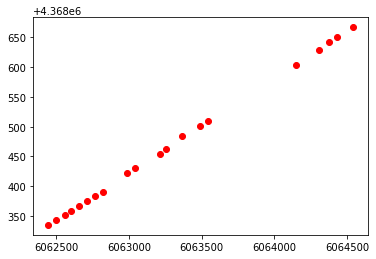

In [46]:
plt.plot(x_save_states,y_save_states, "bx")
plt.plot()

plt.plot(polish_data.iloc[:,2].values,polish_data.iloc[:,3], "ro")
legend_Data = []


In [47]:
print(np.arctan(Y_k/X_k))
print(math.atan2(Y_k, X_k))

0.624388300752206
0.624388300752206


### $\hat{x}^{-}_{k}$

In [48]:
pred_state_mat(a_x,a_y,10,A,X_0,w_k_1)

array([[18.99250635],
       [ 2.15454937],
       [ 3.79850127],
       [ 0.43090987]])

In [49]:
I = np.identity(4)

print(H)
print(R)

K_k = kalman_gain(P_k__, H, R)
print(K_k)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[100.     0.     0.     0.  ]
 [  0.   100.     0.     0.  ]
 [  0.     0.     0.25   0.  ]
 [  0.     0.     0.     0.25]]
[[0.3  0.3  4.   4.  ]
 [0.3  0.3  4.   4.  ]
 [0.01 0.01 0.2  0.2 ]
 [0.01 0.01 0.2  0.2 ]]


In [50]:
print(delta_X(a_x,-1))
X_k = X_coord + delta_X(a_x,17)
Y_k = Y_coord + delta_Y(a_y,11)
print(X_k)
print(Y_k)

0.18992506347188576
6062499.8883433435
4368337.607004732


In [51]:

myIterator = 1
V_k,cog,cog_k_1,rot,delta_time, a_x, a_y,X_coord, Y_coord = get_data_from_dataframe(polish_data,myIterator)


print(V_k)
print(cog)

myTime = 10-deltaTime
print("myTime",myTime)

a_x = calc_a_x(V_k, cog, rot, cog_k_1,myTime)
a_y = calc_a_y(V_k, cog, rot, cog_k_1,myTime)

print(a_x)
print(a_y)

print("\n\n\nx",polish_data.iloc[myIterator,2] + delta_X(a_x,myTime))

print("y",polish_data.iloc[myIterator,3] + delta_Y(a_y,myTime))

deltaTime:  11
5.2
5.1
myTime -1
-4.182568846271218
-0.38512769905626854



x 6062497.908715577
y 4368342.8074361505


## A new approach

In [52]:
time_intervals = np.array([np.arange(0,390, step = 10)])
time_intervals

#estimated_df_kalman =  pd.DataFrame(time_intervals)
old_times = np.array([polish_data.iloc[:,0].values])


estimated_df_kalman = np.concatenate((time_intervals,old_times), axis = 1)
estimated_df_kalman = np.sort(np.unique(estimated_df_kalman[0]))
estimated_df_kalman = pd.DataFrame(estimated_df_kalman)


myKeep = []
HaveValue = []
EstimateThisValue = []
myTimeDiff = []
for i in range(0,len(estimated_df_kalman)):
    if(estimated_df_kalman.iloc[i,0] % 10 == 0):
        myKeep.append(1)
    else:
        myKeep.append(0)

    if(estimated_df_kalman.iloc[i,0] in old_times[0]):
        HaveValue.append(1)
    else:
        HaveValue.append(0)
        
    
    if(myKeep[i] == 1 and HaveValue[i] == 0):
        EstimateThisValue.append(1)
    else:
        EstimateThisValue.append(0)
        
    #Calculate the difference
    if(EstimateThisValue[i] == 1):
        myTimeDiff.append(estimated_df_kalman.iloc[i,0]-estimated_df_kalman.iloc[i-1,0])
    else:
        myTimeDiff.append(0)
    
        
    
        

estimated_df_kalman["EstimateThisValue"] = EstimateThisValue
estimated_df_kalman["myTimeDiff"] = myTimeDiff
# estimated_df_kalman["ToEstimate"] = myKeep
# estimated_df_kalman["HaveValue"] = HaveValue


print(np.sum(HaveValue))
print(estimated_df_kalman)


20
      0  EstimateThisValue  myTimeDiff
0     0                  0           0
1    10                  1          10
2    11                  0           0
3    20                  0           0
4    29                  0           0
5    30                  1           1
6    39                  0           0
7    40                  1           1
8    50                  0           0
9    60                  0           0
10   70                  1          10
11   71                  0           0
12   80                  1           9
13   90                  1          10
14   99                  0           0
15  100                  1           1
16  110                  0           0
17  120                  1          10
18  130                  1          10
19  140                  0           0
20  149                  0           0
21  150                  1           1
22  160                  1          10
23  170                  0           0
24  180               

In [53]:
X_0 =  np.array([[0],[0],[0],[0]])

Estimate_state = pred_state_mat(a_x,a_y,timeDiff,A,prev_state_mat,w_k_1):

SyntaxError: invalid syntax (<ipython-input-53-f5aeab8e869c>, line 3)

In [71]:
print(R)

[[100.     0.     0.     0.  ]
 [  0.   100.     0.     0.  ]
 [  0.     0.     0.25   0.  ]
 [  0.     0.     0.     0.25]]


In [114]:
np.random.normal(0, Q, size=(4,1))
np.random.normal(0, R, size=(4,1))

array([[-26.48537918],
       [  0.        ],
       [  0.        ],
       [  0.        ]])